In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
out_path = "../out/bert_teacher"

results_dict = {}

learning_rates = [2e-5, 3e-5, 5e-5]
n_epochs = [3]
hidden_dropout_probs = [0.2, 0.3]
attention_dropout_probs = [0.2, 0.3]
classifier_dropout_probs = [0.2, 0.3]

for epochs in n_epochs:
    if epochs not in results_dict:
        results_dict[epochs] = {}
    for learning_rate in learning_rates:
        if learning_rate not in results_dict[epochs]:
            results_dict[epochs][learning_rate] = {}
        for hidden_dropout in hidden_dropout_probs:
            if hidden_dropout not in results_dict[epochs][learning_rate]:
                results_dict[epochs][learning_rate][hidden_dropout] = {}
            for attention_dropout in attention_dropout_probs:
                if attention_dropout not in results_dict[epochs][learning_rate][hidden_dropout]:
                    results_dict[epochs][learning_rate][hidden_dropout][attention_dropout] = {}
                for classifier_dropout in classifier_dropout_probs:
                    if classifier_dropout not in results_dict[epochs][learning_rate][hidden_dropout][attention_dropout]:
                        results_dict[epochs][learning_rate][hidden_dropout][attention_dropout][classifier_dropout] = {}
                    result_dir = f'temp_e{int(epochs)}_lr{int(float(learning_rate) * 100000)}_hd{int(hidden_dropout * 100):03d}_ad{int(attention_dropout * 100):03d}_cd{int(classifier_dropout * 100):03d}'
                    results_path = os.path.join(out_path, result_dir, "results/results.json")
                    try:
                        with open(results_path, 'r') as file:
                            results = json.load(file)
                            results_dict[epochs][learning_rate][hidden_dropout][attention_dropout][classifier_dropout] = results
                    except FileNotFoundError:
                        print(f"Results file not found for version: {result_dir}")
                    except json.JSONDecodeError:
                        print(f"Error decoding JSON for version: {result_dir}")


In [3]:
# plot f1 by learning rate and dropout probabilities
f1s = np.zeros((len(learning_rates), len(hidden_dropout_probs), len(attention_dropout_probs), len(classifier_dropout_probs)))
for i, lr in enumerate(learning_rates):
    for j, hd in enumerate(hidden_dropout_probs):
        for k, ad in enumerate(attention_dropout_probs):
            for l, cd in enumerate(classifier_dropout_probs):
                f1s[i, j, k, l] = results_dict[3][lr][hd][ad][cd]['f1_score']

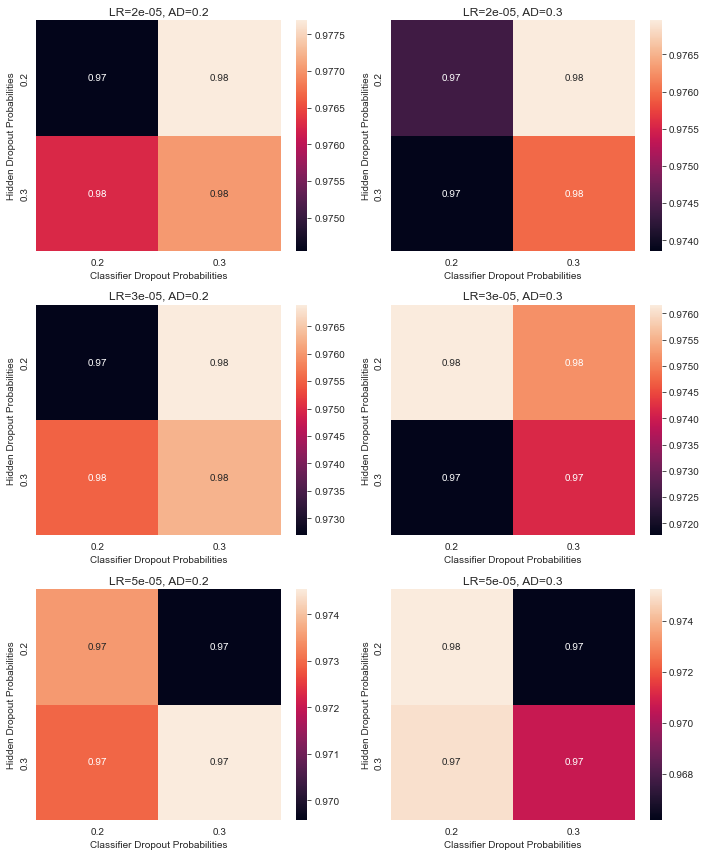

In [4]:
n_lr = len(learning_rates)
n_ad = len(attention_dropout_probs)

fig, axs = plt.subplots(n_lr, n_ad, figsize=(n_ad*5, n_lr*4))

for i, lr in enumerate(learning_rates):
    for j, ad in enumerate(attention_dropout_probs):
        f1_slice = f1s[i, :, j, :]

        if n_lr > 1 and n_ad > 1:
            ax = axs[i, j]
        elif n_lr > 1:
            ax = axs[i]
        else:
            ax = axs[j]

        sns.heatmap(f1_slice, annot=True, fmt=".2f", xticklabels=classifier_dropout_probs, yticklabels=hidden_dropout_probs, ax=ax)
        ax.set_title(f'LR={lr}, AD={ad}')
        ax.set_xlabel('Classifier Dropout Probabilities')
        ax.set_ylabel('Hidden Dropout Probabilities')

plt.tight_layout()

In [6]:
# get lowest, highest f1
results_dict[3][5e-5][0.2][0.3][0.3]['f1_score'], results_dict[3][2e-5][0.2][0.2][0.3]['f1_score']

(0.9661858595412627, 0.9776915615906887)

In [51]:
print(results_dict[3][5e-5][0.2][0.3][0.3]['f1_score'])
print(results_dict[3][5e-5][0.2][0.3][0.3]['nll_score'])
print(results_dict[3][5e-5][0.2][0.3][0.3]['average_inference_time'])
print(results_dict[3][5e-5][0.2][0.3][0.3]['accuracy_score'])

0.9781871061560833
0.10146628728281493
58.722939579788964
0.9636803874092009


In [12]:
# sensitivity of F1 to hyperparameters - keeping others constant
# Fixed indices for simplicity, choose based on your specific criteria
fixed_lr = 2e-05
fixed_hd = 0.2
fixed_ad = 0.2
fixed_cd = 0.3

# for lr
f1_scores_for_varying_lr = [results_dict[3][lr][fixed_hd][fixed_ad][fixed_cd]['f1_score'] for lr in learning_rates]
# for hd 
f1_scores_for_varying_hd = [results_dict[3][fixed_lr][hd][fixed_ad][fixed_cd]['f1_score'] for hd in hidden_dropout_probs]
# for ad
f1_scores_for_varying_ad = [results_dict[3][fixed_lr][fixed_hd][ad][fixed_cd]['f1_score'] for ad in attention_dropout_probs]
# for cd
f1_scores_for_varying_cd = [results_dict[3][fixed_lr][fixed_hd][fixed_ad][cd]['f1_score'] for cd in classifier_dropout_probs]

# Plotting
def plot_sensitivity(parameters_list, f1_scores_list, param_name):
    plt.plot(parameters_list, f1_scores_list, marker='o', linestyle='-')
    plt.xlabel(f'{param_name}')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score Sensitivity to {param_name}')
    plt.grid(True)
    plt.show()

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `results_dict` is accessible and contains the necessary data
def calculate_average_f1s(hyperparam, values):
    avg_f1_scores = []
    std_f1_scores = []
    for value in values:
        f1_scores = []
        for lr in learning_rates:
            for hd in hidden_dropout_probs:
                for ad in attention_dropout_probs:
                    for cd in classifier_dropout_probs:
                        if hyperparam == 'lr':
                            selected_value = lr
                        elif hyperparam == 'hd':
                            selected_value = hd
                        elif hyperparam == 'ad':
                            selected_value = ad
                        elif hyperparam == 'cd':
                            selected_value = cd
                        
                        if selected_value == value:
                            f1_scores.append(results_dict[3][lr][hd][ad][cd]['f1_score'])
        avg_f1_scores.append(np.mean(f1_scores))
        std_f1_scores.append(np.std(f1_scores))
    return avg_f1_scores, std_f1_scores

In [35]:
def plot_sensitivity(parameters_list, f1_scores_list, f1_std_list, param_name):
    plt.plot(parameters_list, f1_scores_list, marker='o', linestyle='-')
    for i, param in enumerate(parameters_list):
        plt.plot([param, param], [f1_scores_list[i] - f1_std_list[i], f1_scores_list[i] + f1_std_list[i]], color='blue')
    plt.xlabel(f'{param_name}')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score Sensitivity to {param_name}')
    plt.grid(True)
    plt.show()

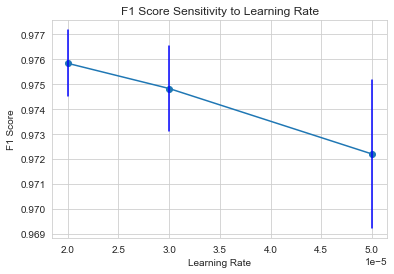

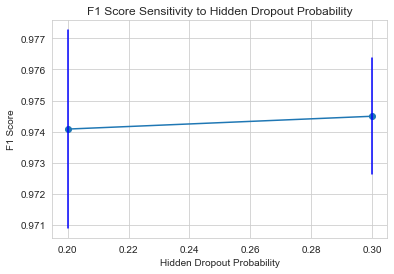

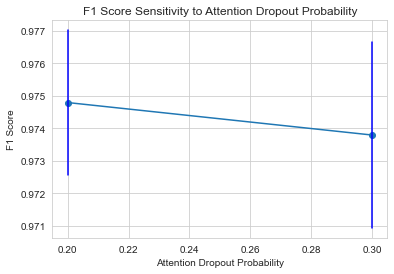

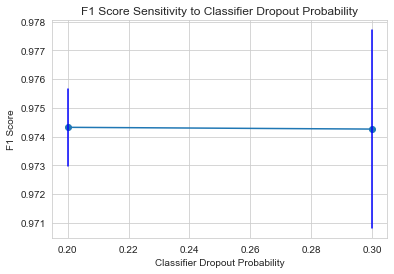

In [36]:
avg_f1s_lr, std_f1s_lr = calculate_average_f1s('lr', learning_rates)
plot_sensitivity(learning_rates, avg_f1s_lr, std_f1s_lr, 'Learning Rate')

avg_f1s_hd, std_f1s_hd = calculate_average_f1s('hd', hidden_dropout_probs)
plot_sensitivity(hidden_dropout_probs, avg_f1s_hd, std_f1s_hd, 'Hidden Dropout Probability')

avg_f1s_ad, std_f1s_ad = calculate_average_f1s('ad', attention_dropout_probs)
plot_sensitivity(attention_dropout_probs, avg_f1s_ad, std_f1s_ad, 'Attention Dropout Probability')

avg_f1s_cd, std_f1s_cd = calculate_average_f1s('cd', classifier_dropout_probs)
plot_sensitivity(classifier_dropout_probs, avg_f1s_cd, std_f1s_cd, 'Classifier Dropout Probability')

# bigger range --> higher sensitivity
# hence, tight means insensitive, wide means sensitive

# LR: 5e-5 is the most sensitive, worst F1, 2e-5 is the least sensitive, best F1

- generally, the choice of hyperparameters appears to matter, but a large range of hyperparameter sets yield a high f1 score
- f1 ranges between 0.966 and 0.978